# 机器学习（进阶）纳米学位毕业项目——猫狗大战


项目来源：[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

**不兼容的库版本：**
- matplotlib(2.1.1)
- keras(2.1.0)

作业环境：
- ubuntu(16.04)
- CUDA(8)
- cuDNN(6)
- tensorflow-gpu(1.4.1)
- h5py(2.7.1)
- matplotlib(2.0.2)
- keras(2.0.8)
- numpy(1.13.3)
- pandas(0.21.1)
- pillow(4.3.0)
- sklearn(0.19.1)
- seaboard(0.8.1)

运行时间：
约 30 分钟

## 项目准备

引入必要的库

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import h5py
import shutil

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from math import ceil

from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dropout, Dense, MaxPooling2D, GlobalMaxPooling2D, Conv2D, Activation
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator, load_img, img_to_array
from keras.applications import resnet50
from keras.applications import inception_v3
from keras.applications import xception

import keras.backend as K
K.set_image_data_format('channels_last')

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

CWD = os.getcwd()
ORIG_TRAIN_IMAGES_DIR = CWD + '/train/'
ORIG_TEST_IMAGES_DIR = CWD + '/test/'

TRAIN_DIR = CWD + '/images/train/'
TRAIN_CAT_DIR = TRAIN_DIR + 'cat/'
TRAIN_DOG_DIR = TRAIN_DIR + 'dog/'

TEST_DIR = CWD + '/images/test/'

Using TensorFlow backend.


模型要求输入的图片使用统一尺寸。由于数据集中原始图片的比例不一致，直接缩放会导致比例失真，因此在图片预处理时需要首先对图片进行 padding 操作，为比例不合要求的图片填充白色底边。

为实现这个目的，自定义了 `MyImageDataGenerator` 类和 `MyDirectoryIterator` 类，分别继承了 Keras 中的 `ImageDataGenerator` 类和 `DirectoryIterator` 类，并改写了必要的方法，以在 `resize` 图片前增加 padding 步骤。

在下面的表述中对类名不予区分，仍然使用 `ImageDataGenerator` 和 `DirectoryIterator` 的名称。

**注意：**自定义类要求 `keras 2.0.8`。因为在 `keras 2.1.0` 中这两个类的实现略有不同，无法兼容。

In [2]:
# %load ./image.py
from image import MyImageDataGenerator, pad_image

`ImageDataGenerator` 要求以文件夹区分不同分类的数据。为节约存储空间，使用 `symblo link` 为训练集和测试集建立副本。文件夹结构为：

```
├── train // 原始数据集
├── test  // 原始测试集
└── images
     └── train
     │    └── cat // symbol link
     │    └── dog // symbol link
     └── test
           └── test // symbol link
```

In [3]:
train_fnames = os.listdir(ORIG_TRAIN_IMAGES_DIR)
cat_fnames = [fname for fname in train_fnames if 'cat' in fname]
dog_fnames = [fname for fname in train_fnames if 'dog' in fname]

test_fnames = os.listdir(ORIG_TEST_IMAGES_DIR)

In [4]:
def link_files(src, dest, fnames):
    if os.path.exists(dest):
        shutil.rmtree(dest)

    os.makedirs(dest)
    
    for fname in fnames:
        os.symlink(src + fname, dest + fname)

link_files(ORIG_TRAIN_IMAGES_DIR, TRAIN_CAT_DIR, cat_fnames)
link_files(ORIG_TRAIN_IMAGES_DIR, TRAIN_DOG_DIR, dog_fnames)

link_files(ORIG_TEST_IMAGES_DIR, TEST_DIR + 'test/', test_fnames)

---

## 探索数据集

### 图片数量

训练数据集中共有 25,000 张图片，其中猫类 12,500 张，狗类 12,500 张，两种分类平均分布。

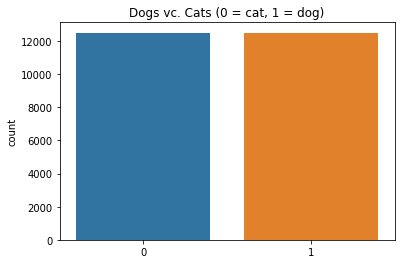

In [5]:
labels = [0 if 'cat' in fname else 1 for fname in train_fnames]

sns.countplot(labels)
plt.title('Dogs vc. Cats (0 = cat, 1 = dog)')

### 图片可视化

数据集中的图片来自日常拍摄的照片。这些图片的尺寸和数量各异，还有些图片中有不止一只动物（但猫狗不会出现在一张图片中），或有人类等干扰性内容。

在预处理时，需要考虑统一图片的比例和尺寸问题：
1. 采用填充白边的方式，将图片统一为正方形
2. 将图片缩放至模型要求的尺寸

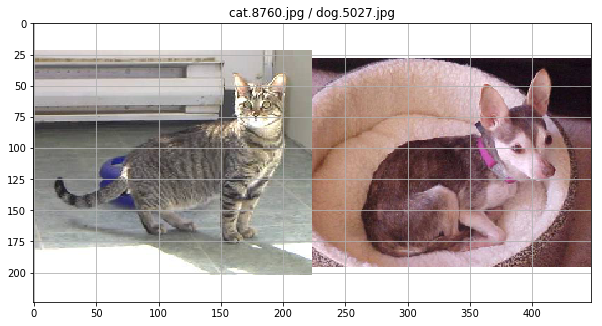

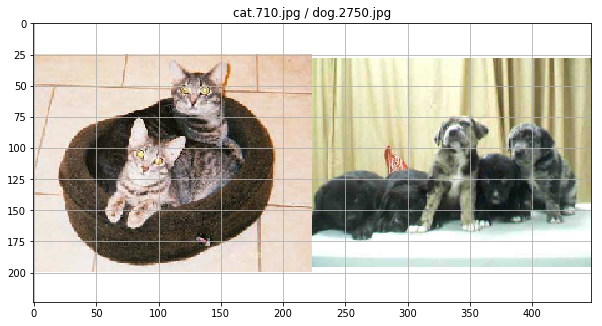

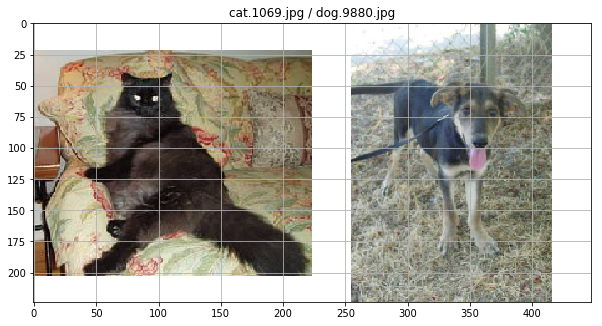

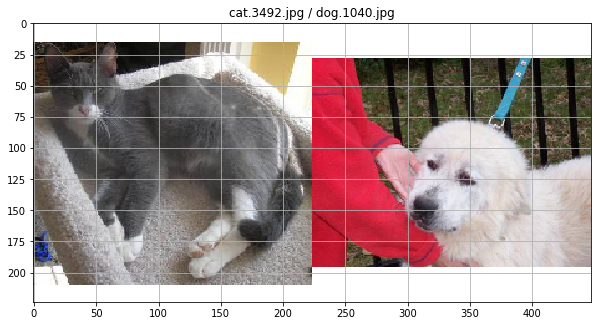

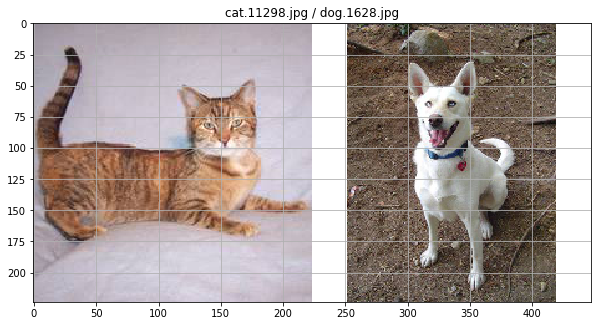

In [6]:
def read_image(fname):
    img = load_img(ORIG_TRAIN_IMAGES_DIR + fname)
    img = pad_image(img)
    img = img.resize((224, 224))

    return img

def preview_images(index):
    cat_img = read_image(cat_fnames[index])
    dog_img = read_image(dog_fnames[index])
    
    pair = np.concatenate((cat_img, dog_img), axis=1)
    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.title(cat_fnames[index] + ' / ' + dog_fnames[index])
    plt.imshow(pair)
    plt.show()
    
for i in range(0,5):
    preview_images(i)

### CNN 与图片识别

通过对一张图片进行简单的卷积网络计算，从直观上理解 CNN 与图片分类。

对示例图片使用 3 个 $3 \times 3$ 的 `kernel` 进行一次卷积计算。因为模型未经过训练，所有权重都是随机的，且 3 个输出层堆叠在一起，看起来完全是噪点，无法直接看到内容。

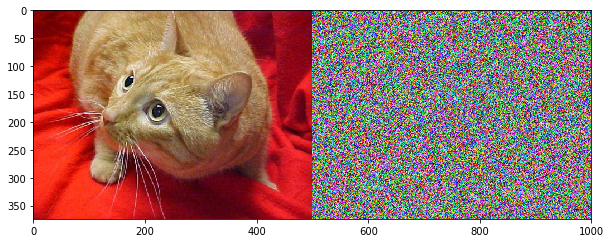

In [7]:
orig_img = load_img(ORIG_TRAIN_IMAGES_DIR + 'cat.18.jpg')
orig_img = img_to_array(orig_img)

model = Sequential()
model.add(Conv2D(3, (3, 3), padding='same', input_shape=orig_img.shape))

img_batch = np.expand_dims(orig_img, axis=0)
conv_img_batch = model.predict(img_batch)
conv_img = np.squeeze(conv_img_batch, axis=0)

pair = np.concatenate((orig_img / 255., conv_img), axis=1)
plt.figure(figsize=(10,10))
plt.imshow(pair)
plt.show()

使用 1 个 `kernel` 进行卷积计算，只观察一层，同时加一个最大池化层，可以看到模型在图片中找到了猫的轮廓，尤其是对眼睛和胡须非常敏感。

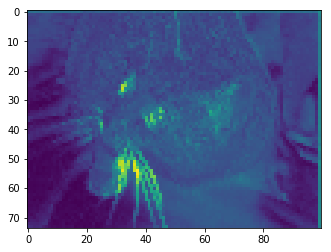

In [8]:
model = Sequential()
model.add(Conv2D(1, (3, 3), padding='same', input_shape=orig_img.shape))
model.add(MaxPooling2D(pool_size=(5, 5)))

img_batch = np.expand_dims(orig_img, axis=0)
conv_img_batch = model.predict(img_batch)
conv_img = np.squeeze(conv_img_batch, axis=0)

conv_img = conv_img.reshape(conv_img.shape[:2])
plt.imshow(conv_img)

---

## 训练模型

这里我选择 ResNet50、InceptionV3 和 Xception 这三个模型。这三个模型对图片分类都有不错的性能，我将分别使用三个模型进行预测，最后将三个模型合并使用，并对四次预测结果进行对比评估。

Keras 提供了这三个模型，以及 ImageNet 的训练权重，因此我将采用迁移学习的方法进行训练：保留原始模型的多数层，将最后的全连接层和输出层替换为自己的模型。

### 输出特征向量

这三个模型都很大，需要大量的计算力，而由于采用迁移学习，前面大部分层是“冻结”的，因此如果直接跑全部模型，会有极大的浪费。因此，可以先用不同模型的固定层输出特征向量，再针对特征向量使用自定义的模型进行训练，可以极大地减少计算量。

在 AWS 的 p2.xlarge 实例上进行三个模型输出特征向量的计算大约需要 30 分钟。

In [9]:
def save_features(MODEL, preprocessor, image_size):
    model_name = MODEL.__name__.lower()
    batch_size = 16
    input_shape=(image_size[0], image_size[1], 3)
    
    save_fname = 'feature_' + model_name + '.h5'
    if os.path.isfile(save_fname):
        return

    base_model = MODEL(include_top=False, weights='imagenet', input_shape=input_shape)
    X = base_model.output
    X = GlobalMaxPooling2D()(X)
    model = Model(inputs=base_model.input, outputs=X, name='my_' + model_name)

    IDG = MyImageDataGenerator(preprocessing_function=preprocessor)
    train_generator = IDG.flow_from_directory(TRAIN_DIR, image_size, shuffle=False, batch_size=batch_size)
    test_generator = IDG.flow_from_directory(TEST_DIR, image_size, class_mode=None, shuffle=False, batch_size=batch_size)
    
    train_feature = model.predict_generator(train_generator, ceil(train_generator.samples / batch_size), verbose=1)
    test_feature = model.predict_generator(test_generator, ceil(test_generator.samples / batch_size), verbose=1)
    
    with h5py.File(save_fname, 'w') as f:
        f.create_dataset('train_feature', data=train_feature)
        f.create_dataset('test_feature', data=test_feature)
        f.create_dataset('train_labels', data=train_generator.classes)

In [10]:
save_features(resnet50.ResNet50, resnet50.preprocess_input, (224, 224))
save_features(inception_v3.InceptionV3, inception_v3.preprocess_input, (299, 299))
save_features(xception.Xception, xception.preprocess_input, (299, 299))

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 141s   
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 209s   
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 273s   


### 训练模型

针对特征向量，使用自定义模型进行训练。相对于选择的三个模型而言，本项目的图片分类任务相对比较简单，自定义模型只采用一次 `dropout` 并输出。因为是一个二元分类问题，输出层激活函数使用 `sigmoid` 函数。

针对每个模型，对训练中的 `logloss` 和 `accuracy` 进行可视化。可以看到，由于前期进行了预训练，这里的训练一开始准确度就非常高，最终在验证集上的准确度达到 0.98-0.99 以上的水平，已经接近贝叶斯最优水平。

对比三个模型，可以看到 ResNet50 的训练集曲线和验证集曲线出现一定的分离，表示该模型对训练集有过拟合的倾向。相对而言，另外两个模型有着更好的泛化性能。

最后，综合三个模型的特征向量进行训练，同样得到了非常好的结果。本项目选择的指标是对数损失，在验证集上的结果四个模型不分伯仲，最终将以提交到 Kaggle 的测试集结果作为评估依据。

In [11]:
def split_train_data(feature_fname):
    with h5py.File(feature_fname, 'r') as f:
        X_train = np.array(f['train_feature'])
        y_train = np.array(f['train_labels'])
        X_test = np.array(f['test_feature'])
        
    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_test

In [12]:
def train_model(X_input, y_input):
    input_tensor = Input(X_train.shape[1:])
    X = Dropout(0.5)(input_tensor)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(input_tensor, X)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    return model

In [13]:
df = pd.read_csv('sample_submission.csv')

def predict(save_fname, model, X_test):
    if os.path.isfile(save_fname):
        os.remove(save_fname)
        
    IDG = MyImageDataGenerator()
    test_generator = IDG.flow_from_directory(TEST_DIR, batch_size=16, class_mode=None)

    pred = model.predict(X_test)
    pred = pred.clip(min=0.005, max=0.995)
    
    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[(fname.rfind('/') + 1):fname.rfind('.')])
        df['label'].at[index - 1] = pred[i]
        
    df.to_csv(save_fname, index=None)
    df.head(10)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.1276 - acc: 0.9511 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.0498 - acc: 0.9828 - val_loss: 0.0449 - val_acc: 0.9834
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.0427 - acc: 0.9844 - val_loss: 0.0427 - val_acc: 0.9834
Epoch 4/10
20000/20000 [==============================] - 0s - loss: 0.0398 - acc: 0.9847 - val_loss: 0.0419 - val_acc: 0.9840
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.0372 - acc: 0.9865 - val_loss: 0.0405 - val_acc: 0.9846
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.0361 - acc: 0.9867 - val_loss: 0.0410 - val_acc: 0.9838
Epoch 7/10
20000/20000 [==============================] - 0s - loss: 0.0342 - acc: 0.9873 - val_loss: 0.0400 - val_acc: 0.9850
Epoch 8/10
20000/20000 [==============================] - 0s -

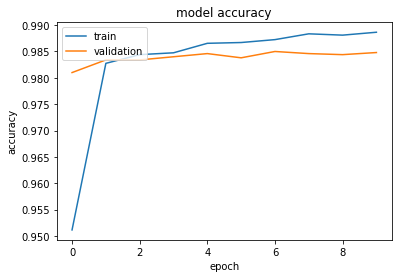

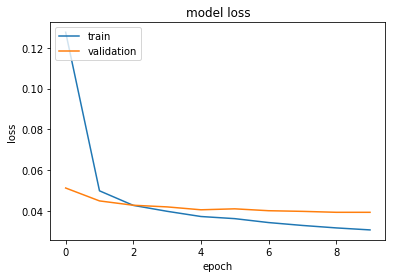

Found 12500 images belonging to 1 classes.


In [14]:
X_train, y_train, X_test = split_train_data('feature_resnet50.h5')
rs50_model = train_model(X_train, y_train)
predict('pred_resnet50.csv', rs50_model, X_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.2293 - acc: 0.9310 - val_loss: 0.0286 - val_acc: 0.9908
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.0732 - acc: 0.9810 - val_loss: 0.0237 - val_acc: 0.9918
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.0598 - acc: 0.9849 - val_loss: 0.0245 - val_acc: 0.9916
Epoch 4/10
20000/20000 [==============================] - 0s - loss: 0.0496 - acc: 0.9864 - val_loss: 0.0241 - val_acc: 0.9920
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.0461 - acc: 0.9874 - val_loss: 0.0384 - val_acc: 0.9896
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.0482 - acc: 0.9882 - val_loss: 0.0252 - val_acc: 0.9924
Epoch 7/10
20000/20000 [==============================] - 0s - loss: 0.0434 - acc: 0.9886 - val_loss: 0.0256 - val_acc: 0.9926
Epoch 8/10
20000/20000 [==============================] - 0s -

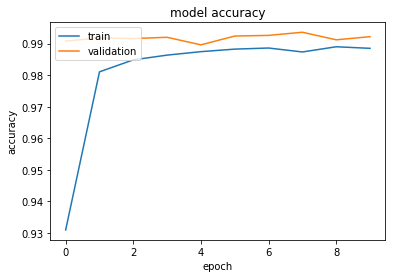

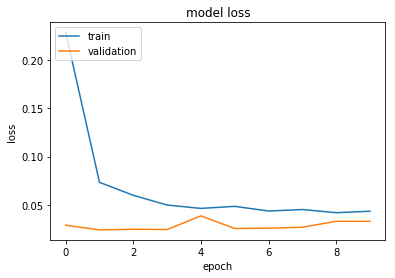

Found 12500 images belonging to 1 classes.


In [15]:
X_train, y_train, X_test = split_train_data('feature_inceptionv3.h5')
v3_model = train_model(X_train, y_train)
predict('pred_inception_v3.csv', v3_model, X_test)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.1055 - acc: 0.9602 - val_loss: 0.0269 - val_acc: 0.9914
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.0376 - acc: 0.9887 - val_loss: 0.0250 - val_acc: 0.9922
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.0320 - acc: 0.9899 - val_loss: 0.0242 - val_acc: 0.9922
Epoch 4/10
20000/20000 [==============================] - 0s - loss: 0.0294 - acc: 0.9913 - val_loss: 0.0244 - val_acc: 0.9924
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.0268 - acc: 0.9926 - val_loss: 0.0275 - val_acc: 0.9902
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.0255 - acc: 0.9919 - val_loss: 0.0253 - val_acc: 0.9920
Epoch 7/10
20000/20000 [==============================] - 0s - loss: 0.0255 - acc: 0.9924 - val_loss: 0.0269 - val_acc: 0.9908
Epoch 8/10
20000/20000 [==============================] - 0s -

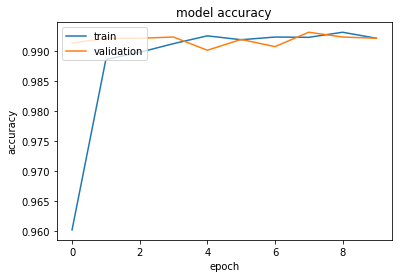

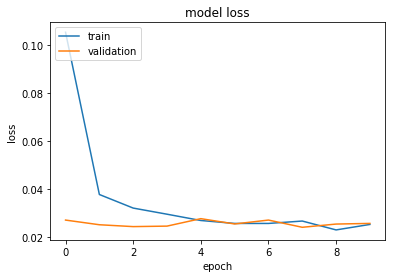

Found 12500 images belonging to 1 classes.


In [16]:
X_train, y_train, X_test = split_train_data('feature_xception.h5')
xc_model = train_model(X_train, y_train)
predict('pred_xception.csv', xc_model, X_test)

In [17]:
def merge_features():
    X_train = []
    X_test = []
    for fname in ['feature_resnet50.h5', 'feature_inceptionv3.h5', 'feature_xception.h5']:
        with h5py.File(fname, 'r') as f:
            X_train.append(np.array(f['train_feature']))
            y_train = np.array(f['train_labels'])
            X_test.append(np.array(f['test_feature']))
    
    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)
    
    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_test

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.0948 - acc: 0.9691 - val_loss: 0.0246 - val_acc: 0.9918
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.0288 - acc: 0.9911 - val_loss: 0.0252 - val_acc: 0.9930
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.0278 - acc: 0.9930 - val_loss: 0.0226 - val_acc: 0.9934
Epoch 4/10
20000/20000 [==============================] - 0s - loss: 0.0249 - acc: 0.9930 - val_loss: 0.0226 - val_acc: 0.9930
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0261 - val_acc: 0.9934
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.0201 - acc: 0.9947 - val_loss: 0.0290 - val_acc: 0.9920
Epoch 7/10
20000/20000 [==============================] - 0s - loss: 0.0165 - acc: 0.9950 - val_loss: 0.0232 - val_acc: 0.9930
Epoch 8/10
20000/20000 [==============================] - 0s -

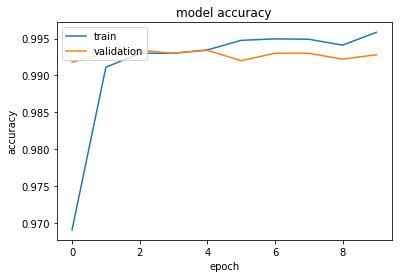

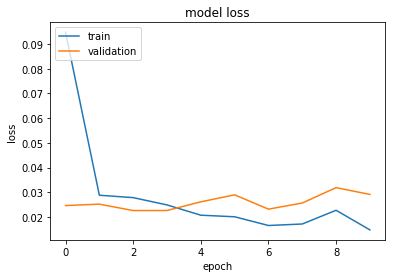

Found 12500 images belonging to 1 classes.


In [18]:
X_train, y_train, X_test = merge_features()
merge_model = train_model(X_train, y_train)
predict('pred.csv', merge_model, X_test)

***